In [26]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 60

In [3]:
def create_image_pairs(dataset):
    image_pairs = []
    labels = []

    max_size_class = len(dataset) // 3  # Limita il numero massimo di campioni per ciascuna classe
    count_class_0 = 0  # Contatore per la classe A > B
    count_class_1 = 0  # Contatore per la classe A < B
    count_class_2 = 0  # Contatore per la classe A = B
    i = 0
    
    # Continua finché tutte le classi non sono bilanciate
    while count_class_0 < max_size_class or count_class_1 < max_size_class or count_class_2 < max_size_class:
        img_A, label_A = dataset[i]

        class_busy = True
        while class_busy:  # Cerca una relazione valida che non sia satura
            idx_B = random.randint(0, len(dataset) - 1)
            img_B, label_B = dataset[idx_B]

            # Determina la relazione tra le etichette
            if label_A > label_B:
                relation_label = 0  # A > B
            elif label_A < label_B:
                relation_label = 1  # A < B
            else:
                relation_label = 2  # A = B

            # Verifica se la classe ha già raggiunto il limite massimo
            if relation_label == 0 and count_class_0 < max_size_class:
                count_class_0 += 1
                class_busy = False
            elif relation_label == 1 and count_class_1 < max_size_class:
                count_class_1 += 1
                class_busy = False
            elif relation_label == 2 and count_class_2 < max_size_class:
                count_class_2 += 1
                class_busy = False

        # Aggiungi la coppia solo se la classe non ha raggiunto il limite massimo
        image_pairs.append((img_A, img_B))
        labels.append(relation_label)
        i += 1

    return image_pairs, labels


In [4]:
# Dataset personalizzato per gestire le coppie di immagini
class MNISTPairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.image_pairs, self.labels = create_image_pairs(dataset)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_A, img_B = self.image_pairs[idx]
        label = self.labels[idx]

        # Concatenare le immagini lungo il canale (depth)
        concatenated_image = torch.cat((img_A, img_B), dim=0)

        return concatenated_image, label


In [5]:
# Funzione per visualizzare una coppia di immagini e la loro etichetta di relazione
def show_image_pair(img_A, img_B, relation_label):
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Converte il tensore in numpy array per visualizzazione
    img_A = img_A.squeeze().numpy()  # Rimuove la dimensione del canale
    img_B = img_B.squeeze().numpy()

    # Crea una figura con due immagini, riducendo la dimensione per occupare meno spazio
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))  # Dimensioni ridotte

    # Mostra le immagini
    axes[0].imshow(img_A, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')  # Rimuove gli assi

    axes[1].imshow(img_B, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')  # Rimuove gli assi

    # Riduce lo spazio tra i subplots
    plt.tight_layout(pad=0.5)  # Riduce il padding tra le immagini

    # Mostra il titolo della relazione
    plt.suptitle(f'Relation: {relation_labels[relation_label]}', y=0.85)  # Posiziona il titolo più vicino
    plt.show()


In [6]:
# Funzione per visualizzare più coppie di immagini in un'unica figura
def show_dataset(dataset, num_images=5):
    dataiter = iter(dataset)
    images, labels = next(dataiter)

    # Mappa delle etichette di relazione
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Numero di righe: ogni riga contiene 1 coppia di immagini (2 colonne)
    num_rows = num_images  # 1 coppia per riga

    # Crea una griglia di subplots: num_rows righe, 3 colonne (Image A, Relation, Image B)
    fig, axes = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    
    for i in range(num_images):
        concatenated_image = images[i]
        label = labels[i].item()

        img_A = concatenated_image[0, :, :]
        img_B = concatenated_image[1, :, :]

        # Mostra l'immagine A nel subplot
        axes[i, 0].imshow(img_A, cmap='gray')
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        # Mostra l'etichetta di relazione nel subplot centrale
        axes[i, 1].text(0.5, 0.5, f'Relation: {relation_labels[label]}', 
                        fontsize=12, ha='center', va='center')
        axes[i, 1].axis('off')

        # Mostra l'immagine B nel subplot
        axes[i, 2].imshow(img_B, cmap='gray')
        axes[i, 2].set_title('Image B')
        axes[i, 2].axis('off')  # Nascondi gli assi

    # Applica il layout compatto per ridurre lo spazio tra i subplot
    plt.tight_layout(pad=0.5)
    plt.show()
    return fig


In [7]:
def dataset_statistics(dataset):
    image_shapes = set()
    pair_relations_counts = collections.Counter()

    for img_pair, label in dataset:
        # Aggiorna la distribuzione delle classi
        pair_relations_counts[label] += 1

        # Controlla la dimensione delle immagini
        image_shapes.add(img_pair.shape)

    # Riassumi le informazioni
    total_samples = len(dataset)
    class_distribution = dict(pair_relations_counts)

    print(f"Numero totale di campioni: {total_samples}")
    print(f"Distribuzione delle relazioni (A > B, A < B, A = B): {class_distribution}")
    print(f"Dimensioni delle immagini trovate nel dataset: {image_shapes}")

    # Calcolo delle percentuali delle classi
    for relation, count in class_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"Relazione {relation}: {count} campioni ({percentage:.2f}%)")
    
    print("\n")
    return class_distribution, image_shapes


In [8]:
def dataset_raw_statistics(dataset):
    class_counts = collections.Counter()
    percentage = {}

    for _, label in dataset:
        class_counts[label] += 1

    for label, count in class_counts.items():
        percentage[label] = (count / len(dataset)) * 100
    
    return class_counts, percentage

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset_statistics(dataset, dataset_name="Dataset"):
    # Ottieni le statistiche con la funzione precedente
    class_distribution, image_shapes = dataset_statistics(dataset)
    
    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")
    
    # 1. Istogramma della distribuzione delle classi (relazioni A > B, A < B, A = B)
    plt.figure(figsize=(10, 6))
    classes = ['A > B', 'A < B', 'A = B']
    counts = [class_distribution.get(0, 0), class_distribution.get(1, 0), class_distribution.get(2, 0)]
    
    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()
    
    # 3. Box plot per esplorare la distribuzione delle classi in percentuale
    plt.figure(figsize=(10, 6))
    percentages = [(count / len(dataset)) * 100 for count in counts]
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale di Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()

In [10]:
def plot_dataset_raw_statistics(dataset, dataset_name="Dataset"):
    class_counts, percentage = dataset_raw_statistics(dataset)

    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Classi')
    plt.show()

    plt.figure(figsize=(10, 6))
    percentages = list(percentage.values())
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Classi')
    plt.show()    

In [11]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [12]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [13]:
def create_train_dataset(transform_dataset=False, augment_dataset=False):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])

    transform_augmented = transforms.Compose([
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomChoice([
            transforms.Lambda(lambda x: add_gaussian_noise(x)),
            transforms.Lambda(lambda x: invert_colors(x)),
            transforms.Lambda(lambda x: x),
        ]),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)
    
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_augmented)

    train_pair_dataset = MNISTPairDataset(train_dataset)
    train_pair_dataset_augmented = MNISTPairDataset(train_dataset_augmented)

    print(f"Dimensione del dataset originale: {len(train_pair_dataset)}")
    print(f"Dimensione del dataset trasformato: {len(train_pair_dataset_augmented)}")

    if augment_dataset:
        train_pair_dataset = torch.utils.data.ConcatDataset([train_pair_dataset, train_pair_dataset_augmented])
        print(f"Dimensione del dataset combinato: {len(train_pair_dataset)}")
    
    if transform_dataset:
        train_pair_dataset = train_pair_dataset_augmented

    return train_pair_dataset, train_dataset


In [14]:
def create_test_dataset(validation_split=0.2):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])
    
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

    test_pair_dataset = MNISTPairDataset(test_dataset)

    total_test_size = len(test_pair_dataset)
 
    validation_size = int(total_test_size * validation_split)
    test_size = total_test_size - validation_size

    test_subset, validation_subset = torch.utils.data.random_split(test_pair_dataset, [test_size, validation_size])
    return test_subset, validation_subset, test_dataset

In [15]:
def create_data_loader(train_dataset, validation_dataset, test_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader

In [16]:
train_dataset, train_dataset_raw = create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = create_test_dataset(validation_split=0.3)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


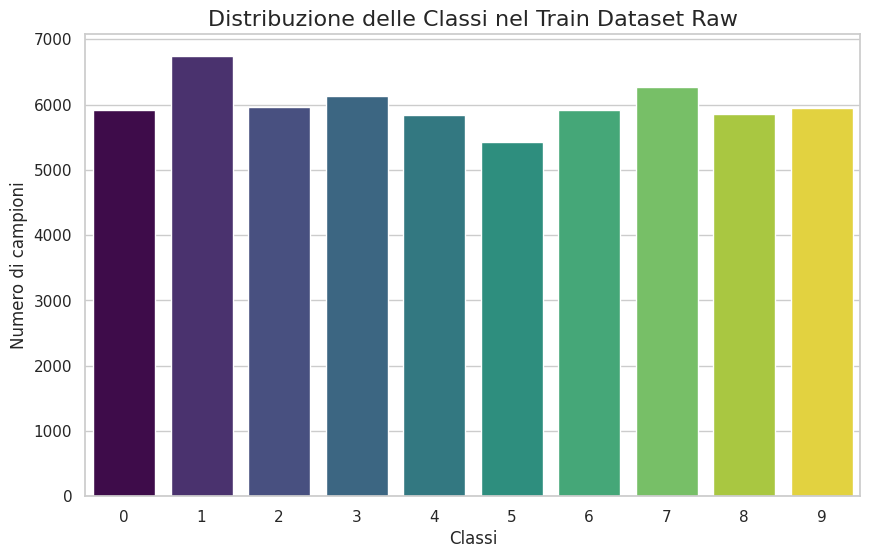

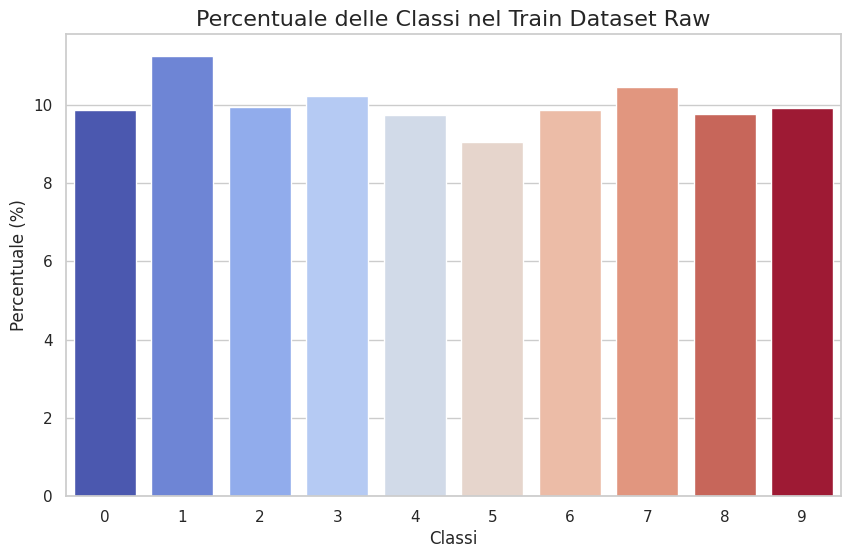

In [17]:
plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




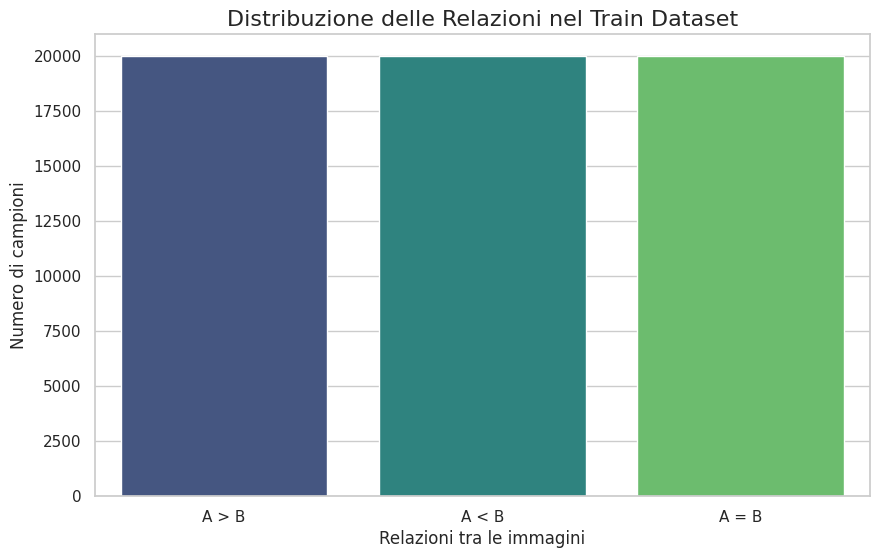

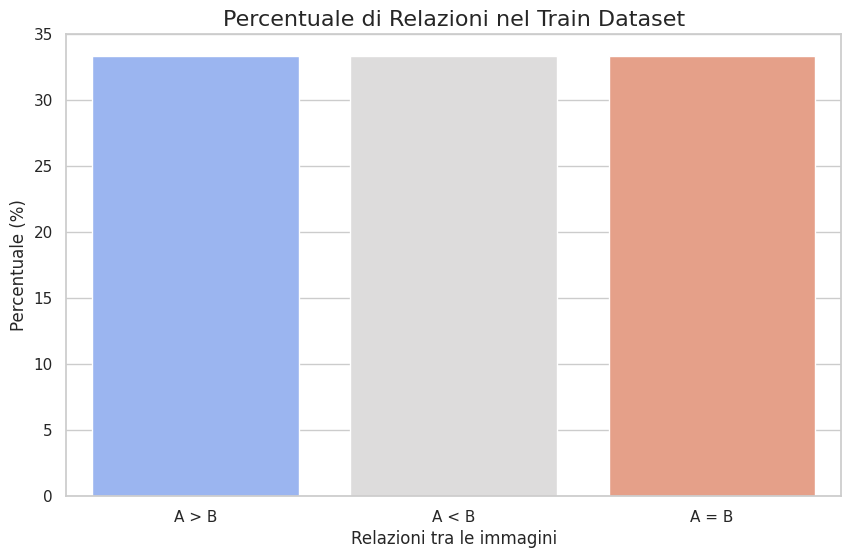

In [18]:
plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2360, 1: 2305, 2: 2335}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2360 campioni (33.71%)
Relazione 1: 2305 campioni (32.93%)
Relazione 2: 2335 campioni (33.36%)




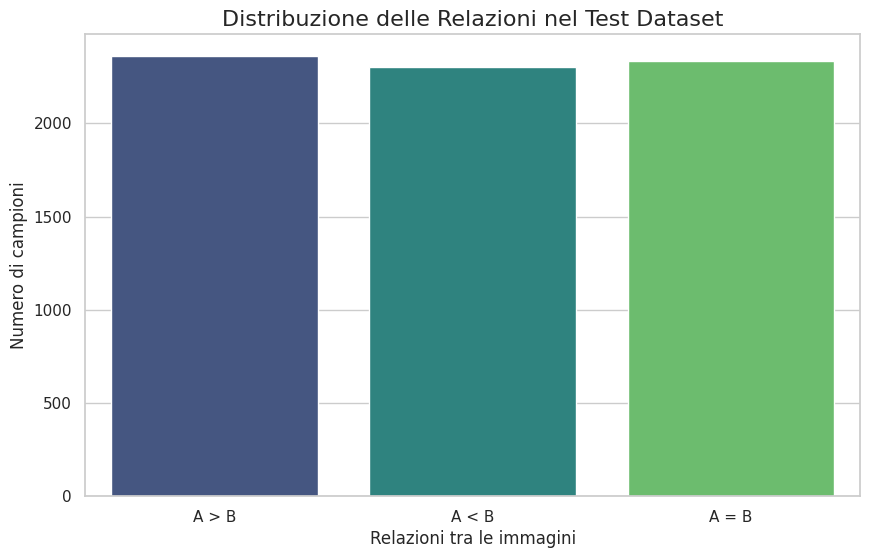

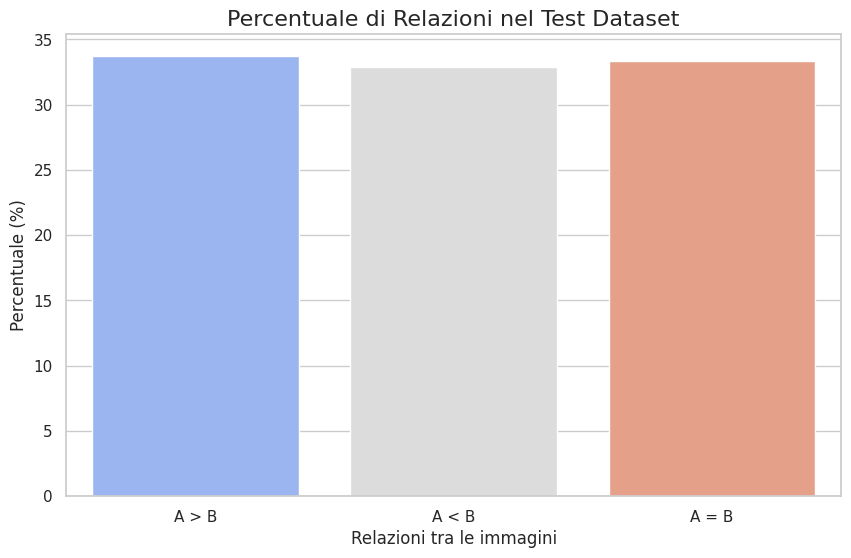

In [19]:
plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 2999
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 1028, 2: 998, 0: 973}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 1: 1028 campioni (34.28%)
Relazione 2: 998 campioni (33.28%)
Relazione 0: 973 campioni (32.44%)




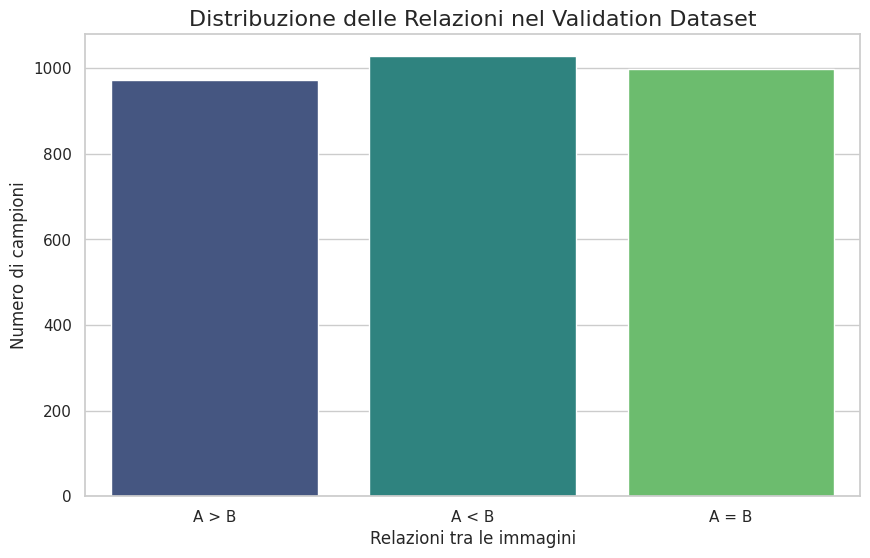

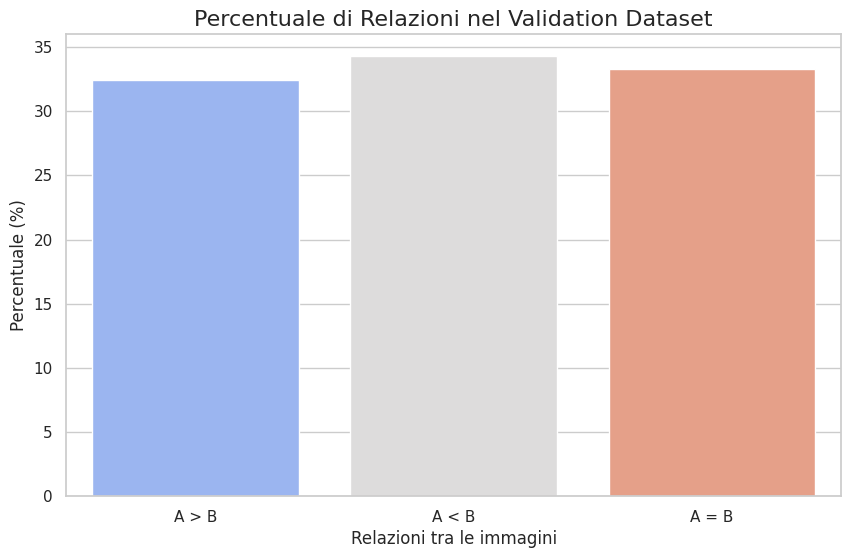

In [20]:
plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [21]:
train_loader, validation_loader, test_loader = create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [22]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  24  Size validation_dataset:  2999
Size test_loader:  55  Size test_dataset:  7000


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
import torch.nn as nn
import torch.nn.functional as F

class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [25]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

images dtype: torch.float32, labels dtype: torch.int64


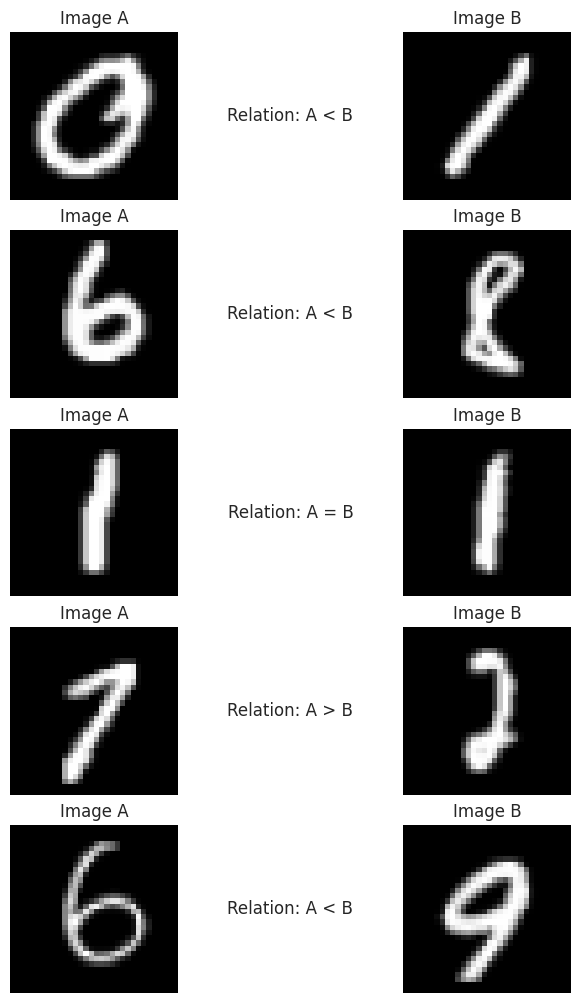

In [27]:
from torch.utils.tensorboard import SummaryWriter

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', show_dataset(train_loader, 5))

In [114]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [115]:
# TRAIN!!!
import time
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 60
Training


Loss: 0.4736: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]


Validating


Loss: 0.4826: 100%|██████████| 24/24 [00:00<00:00, 65.00it/s]


Epoch #1 train loss: 0.634 train accuracy: 72.77
Epoch #1 validation loss: 0.483 validation accuracy: 82.93
Took 0.200 minutes for epoch 1

EPOCH 2 of 60
Training


Loss: 0.3851: 100%|██████████| 469/469 [00:10<00:00, 43.08it/s]


Validating


Loss: 0.3547: 100%|██████████| 24/24 [00:00<00:00, 94.02it/s]


Epoch #2 train loss: 0.350 train accuracy: 86.56
Epoch #2 validation loss: 0.355 validation accuracy: 89.33
Took 0.186 minutes for epoch 2

EPOCH 3 of 60
Training


Loss: 0.1487: 100%|██████████| 469/469 [00:11<00:00, 41.69it/s]


Validating


Loss: 0.3116: 100%|██████████| 24/24 [00:00<00:00, 92.04it/s]


Epoch #3 train loss: 0.249 train accuracy: 90.74
Epoch #3 validation loss: 0.312 validation accuracy: 91.36
Took 0.192 minutes for epoch 3

EPOCH 4 of 60
Training


Loss: 0.1961: 100%|██████████| 469/469 [00:11<00:00, 41.97it/s]


Validating


Loss: 0.3648: 100%|██████████| 24/24 [00:00<00:00, 94.12it/s]


Epoch #4 train loss: 0.197 train accuracy: 92.80
Epoch #4 validation loss: 0.365 validation accuracy: 92.03
Took 0.191 minutes for epoch 4

EPOCH 5 of 60
Training


Loss: 0.2538: 100%|██████████| 469/469 [00:11<00:00, 42.37it/s]


Validating


Loss: 0.2491: 100%|██████████| 24/24 [00:00<00:00, 96.89it/s]


Epoch #5 train loss: 0.159 train accuracy: 94.27
Epoch #5 validation loss: 0.249 validation accuracy: 93.03
Took 0.189 minutes for epoch 5

EPOCH 6 of 60
Training


Loss: 0.0926: 100%|██████████| 469/469 [00:11<00:00, 42.00it/s]


Validating


Loss: 0.2613: 100%|██████████| 24/24 [00:00<00:00, 96.75it/s]


Epoch #6 train loss: 0.134 train accuracy: 95.16
Epoch #6 validation loss: 0.261 validation accuracy: 93.50
Took 0.190 minutes for epoch 6

EPOCH 7 of 60
Training


Loss: 0.0908: 100%|██████████| 469/469 [00:11<00:00, 42.25it/s]


Validating


Loss: 0.2478: 100%|██████████| 24/24 [00:00<00:00, 99.98it/s]


Epoch #7 train loss: 0.114 train accuracy: 95.91
Epoch #7 validation loss: 0.248 validation accuracy: 93.70
Took 0.189 minutes for epoch 7

EPOCH 8 of 60
Training


Loss: 0.0516: 100%|██████████| 469/469 [00:12<00:00, 38.83it/s]


Validating


Loss: 0.2578: 100%|██████████| 24/24 [00:00<00:00, 93.37it/s]


Epoch #8 train loss: 0.095 train accuracy: 96.62
Epoch #8 validation loss: 0.258 validation accuracy: 94.30
Took 0.206 minutes for epoch 8

EPOCH 9 of 60
Training


Loss: 0.0483: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]


Validating


Loss: 0.2868: 100%|██████████| 24/24 [00:00<00:00, 77.00it/s]


Epoch #9 train loss: 0.084 train accuracy: 97.03
Epoch #9 validation loss: 0.287 validation accuracy: 93.70
Took 0.243 minutes for epoch 9

EPOCH 10 of 60
Training


Loss: 0.0866: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]


Validating


Loss: 0.2788: 100%|██████████| 24/24 [00:00<00:00, 92.90it/s]


Epoch #10 train loss: 0.074 train accuracy: 97.31
Epoch #10 validation loss: 0.279 validation accuracy: 94.50
Took 0.200 minutes for epoch 10

EPOCH 11 of 60
Training


Loss: 0.0877: 100%|██████████| 469/469 [00:11<00:00, 41.82it/s]


Validating


Loss: 0.2380: 100%|██████████| 24/24 [00:00<00:00, 95.53it/s]


Epoch #11 train loss: 0.066 train accuracy: 97.63
Epoch #11 validation loss: 0.238 validation accuracy: 94.73
Took 0.191 minutes for epoch 11

EPOCH 12 of 60
Training


Loss: 0.0881: 100%|██████████| 469/469 [00:10<00:00, 43.88it/s]


Validating


Loss: 0.2579: 100%|██████████| 24/24 [00:00<00:00, 93.60it/s]


Epoch #12 train loss: 0.055 train accuracy: 98.01
Epoch #12 validation loss: 0.258 validation accuracy: 94.90
Took 0.183 minutes for epoch 12

EPOCH 13 of 60
Training


Loss: 0.0419: 100%|██████████| 469/469 [00:10<00:00, 44.39it/s]


Validating


Loss: 0.2565: 100%|██████████| 24/24 [00:00<00:00, 95.98it/s]


Epoch #13 train loss: 0.050 train accuracy: 98.26
Epoch #13 validation loss: 0.257 validation accuracy: 94.50
Took 0.180 minutes for epoch 13

EPOCH 14 of 60
Training


Loss: 0.0407: 100%|██████████| 469/469 [00:10<00:00, 43.11it/s]


Validating


Loss: 0.3456: 100%|██████████| 24/24 [00:00<00:00, 100.74it/s]


Epoch #14 train loss: 0.043 train accuracy: 98.44
Epoch #14 validation loss: 0.346 validation accuracy: 94.73
Took 0.185 minutes for epoch 14

EPOCH 15 of 60
Training


Loss: 0.0050: 100%|██████████| 469/469 [00:11<00:00, 42.04it/s]


Validating


Loss: 0.3649: 100%|██████████| 24/24 [00:00<00:00, 95.27it/s]


Epoch #15 train loss: 0.041 train accuracy: 98.60
Epoch #15 validation loss: 0.365 validation accuracy: 94.36
Took 0.190 minutes for epoch 15

EPOCH 16 of 60
Training


Loss: 0.0426: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]


Validating


Loss: 0.2028: 100%|██████████| 24/24 [00:00<00:00, 76.61it/s]


Epoch #16 train loss: 0.037 train accuracy: 98.67
Epoch #16 validation loss: 0.203 validation accuracy: 94.33
Took 0.238 minutes for epoch 16

EPOCH 17 of 60
Training


Loss: 0.0400: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]


Validating


Loss: 0.2821: 100%|██████████| 24/24 [00:00<00:00, 72.98it/s]


Epoch #17 train loss: 0.031 train accuracy: 98.89
Epoch #17 validation loss: 0.282 validation accuracy: 94.66
Took 0.229 minutes for epoch 17

EPOCH 18 of 60
Training


Loss: 0.0636: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]


Validating


Loss: 0.3028: 100%|██████████| 24/24 [00:00<00:00, 78.81it/s]


Epoch #18 train loss: 0.032 train accuracy: 98.83
Epoch #18 validation loss: 0.303 validation accuracy: 95.23
Took 0.225 minutes for epoch 18

EPOCH 19 of 60
Training


Loss: 0.0693: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]


Validating


Loss: 0.3297: 100%|██████████| 24/24 [00:00<00:00, 76.00it/s]


Epoch #19 train loss: 0.027 train accuracy: 99.05
Epoch #19 validation loss: 0.330 validation accuracy: 94.60
Took 0.233 minutes for epoch 19

EPOCH 20 of 60
Training


Loss: 0.0864: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]


Validating


Loss: 0.2748: 100%|██████████| 24/24 [00:00<00:00, 74.92it/s]


Epoch #20 train loss: 0.026 train accuracy: 99.07
Epoch #20 validation loss: 0.275 validation accuracy: 94.86
Took 0.237 minutes for epoch 20

EPOCH 21 of 60
Training


Loss: 0.0455: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]


Validating


Loss: 0.3797: 100%|██████████| 24/24 [00:00<00:00, 78.17it/s]


Epoch #21 train loss: 0.027 train accuracy: 99.01
Epoch #21 validation loss: 0.380 validation accuracy: 94.50
Took 0.233 minutes for epoch 21

EPOCH 22 of 60
Training


Loss: 0.0158: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]


Validating


Loss: 0.3873: 100%|██████████| 24/24 [00:00<00:00, 94.68it/s] 


Epoch #22 train loss: 0.023 train accuracy: 99.17
Epoch #22 validation loss: 0.387 validation accuracy: 94.73
Took 0.250 minutes for epoch 22

EPOCH 23 of 60
Training


Loss: 0.0610: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]


Validating


Loss: 0.2967: 100%|██████████| 24/24 [00:00<00:00, 91.03it/s]


Epoch #23 train loss: 0.024 train accuracy: 99.17
Epoch #23 validation loss: 0.297 validation accuracy: 94.80
Took 0.212 minutes for epoch 23

EPOCH 24 of 60
Training


Loss: 0.0345: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]


Validating


Loss: 0.1840: 100%|██████████| 24/24 [00:00<00:00, 82.06it/s]


Epoch #24 train loss: 0.022 train accuracy: 99.22
Epoch #24 validation loss: 0.184 validation accuracy: 94.70
Took 0.211 minutes for epoch 24

EPOCH 25 of 60
Training


Loss: 0.0195: 100%|██████████| 469/469 [00:10<00:00, 42.94it/s]


Validating


Loss: 0.4459: 100%|██████████| 24/24 [00:00<00:00, 90.38it/s]


Epoch #25 train loss: 0.020 train accuracy: 99.27
Epoch #25 validation loss: 0.446 validation accuracy: 95.10
Took 0.187 minutes for epoch 25

EPOCH 26 of 60
Training


Loss: 0.0775: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]


Validating


Loss: 0.3910: 100%|██████████| 24/24 [00:00<00:00, 90.26it/s]


Epoch #26 train loss: 0.018 train accuracy: 99.34
Epoch #26 validation loss: 0.391 validation accuracy: 95.40
Took 0.222 minutes for epoch 26

EPOCH 27 of 60
Training


Loss: 0.0021: 100%|██████████| 469/469 [00:12<00:00, 38.93it/s]


Validating


Loss: 0.3837: 100%|██████████| 24/24 [00:00<00:00, 79.96it/s]


Epoch #27 train loss: 0.020 train accuracy: 99.33
Epoch #27 validation loss: 0.384 validation accuracy: 95.37
Took 0.206 minutes for epoch 27

EPOCH 28 of 60
Training


Loss: 0.0175: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]


Validating


Loss: 0.5272: 100%|██████████| 24/24 [00:00<00:00, 93.60it/s]


Epoch #28 train loss: 0.016 train accuracy: 99.38
Epoch #28 validation loss: 0.527 validation accuracy: 95.47
Took 0.209 minutes for epoch 28

EPOCH 29 of 60
Training


Loss: 0.0061: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]


Validating


Loss: 0.2591: 100%|██████████| 24/24 [00:00<00:00, 102.72it/s]


Epoch #29 train loss: 0.015 train accuracy: 99.50
Epoch #29 validation loss: 0.259 validation accuracy: 94.70
Took 0.207 minutes for epoch 29

EPOCH 30 of 60
Training


Loss: 0.0254: 100%|██████████| 469/469 [00:11<00:00, 40.65it/s]


Validating


Loss: 0.4174: 100%|██████████| 24/24 [00:00<00:00, 69.72it/s]


Epoch #30 train loss: 0.018 train accuracy: 99.33
Epoch #30 validation loss: 0.417 validation accuracy: 95.30
Took 0.198 minutes for epoch 30

EPOCH 31 of 60
Training


Loss: 0.0063: 100%|██████████| 469/469 [00:11<00:00, 39.34it/s]


Validating


Loss: 0.4306: 100%|██████████| 24/24 [00:00<00:00, 91.77it/s]


Epoch #31 train loss: 0.018 train accuracy: 99.35
Epoch #31 validation loss: 0.431 validation accuracy: 95.03
Took 0.203 minutes for epoch 31

EPOCH 32 of 60
Training


Loss: 0.0092: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]


Validating


Loss: 0.1670: 100%|██████████| 24/24 [00:00<00:00, 73.05it/s]


Epoch #32 train loss: 0.016 train accuracy: 99.45
Epoch #32 validation loss: 0.167 validation accuracy: 95.07
Took 0.223 minutes for epoch 32

EPOCH 33 of 60
Training


Loss: 0.0375: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]


Validating


Loss: 0.4153: 100%|██████████| 24/24 [00:00<00:00, 75.22it/s]


Epoch #33 train loss: 0.018 train accuracy: 99.39
Epoch #33 validation loss: 0.415 validation accuracy: 95.23
Took 0.250 minutes for epoch 33

EPOCH 34 of 60
Training


Loss: 0.0042: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]


Validating


Loss: 0.1668: 100%|██████████| 24/24 [00:00<00:00, 73.78it/s]


Epoch #34 train loss: 0.012 train accuracy: 99.54
Epoch #34 validation loss: 0.167 validation accuracy: 95.27
Took 0.239 minutes for epoch 34

EPOCH 35 of 60
Training


Loss: 0.0073: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]


Validating


Loss: 0.3967: 100%|██████████| 24/24 [00:00<00:00, 70.07it/s]


Epoch #35 train loss: 0.013 train accuracy: 99.56
Epoch #35 validation loss: 0.397 validation accuracy: 95.43
Took 0.224 minutes for epoch 35

EPOCH 36 of 60
Training


Loss: 0.0559: 100%|██████████| 469/469 [00:12<00:00, 36.37it/s]


Validating


Loss: 0.3817: 100%|██████████| 24/24 [00:00<00:00, 78.31it/s]


Epoch #36 train loss: 0.022 train accuracy: 99.28
Epoch #36 validation loss: 0.382 validation accuracy: 95.43
Took 0.220 minutes for epoch 36

EPOCH 37 of 60
Training


Loss: 0.0055: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]


Validating


Loss: 0.4816: 100%|██████████| 24/24 [00:00<00:00, 51.14it/s]


Epoch #37 train loss: 0.011 train accuracy: 99.61
Epoch #37 validation loss: 0.482 validation accuracy: 95.63
Took 0.224 minutes for epoch 37

EPOCH 38 of 60
Training


Loss: 0.0004: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]


Validating


Loss: 0.4577: 100%|██████████| 24/24 [00:00<00:00, 75.97it/s]


Epoch #38 train loss: 0.011 train accuracy: 99.65
Epoch #38 validation loss: 0.458 validation accuracy: 95.00
Took 0.222 minutes for epoch 38

EPOCH 39 of 60
Training


Loss: 0.0045: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]


Validating


Loss: 0.1928: 100%|██████████| 24/24 [00:00<00:00, 84.48it/s]


Epoch #39 train loss: 0.019 train accuracy: 99.37
Epoch #39 validation loss: 0.193 validation accuracy: 95.87
Took 0.227 minutes for epoch 39

EPOCH 40 of 60
Training


Loss: 0.0136: 100%|██████████| 469/469 [00:12<00:00, 36.87it/s]


Validating


Loss: 0.3732: 100%|██████████| 24/24 [00:00<00:00, 77.01it/s]


Epoch #40 train loss: 0.011 train accuracy: 99.63
Epoch #40 validation loss: 0.373 validation accuracy: 95.37
Took 0.217 minutes for epoch 40

EPOCH 41 of 60
Training


Loss: 0.0183: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]


Validating


Loss: 0.3193: 100%|██████████| 24/24 [00:00<00:00, 72.35it/s]


Epoch #41 train loss: 0.015 train accuracy: 99.47
Epoch #41 validation loss: 0.319 validation accuracy: 95.53
Took 0.221 minutes for epoch 41

EPOCH 42 of 60
Training


Loss: 0.0216: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]


Validating


Loss: 0.5671: 100%|██████████| 24/24 [00:00<00:00, 69.40it/s]


Epoch #42 train loss: 0.011 train accuracy: 99.59
Epoch #42 validation loss: 0.567 validation accuracy: 94.96
Took 0.247 minutes for epoch 42

EPOCH 43 of 60
Training


Loss: 0.0056: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]


Validating


Loss: 0.1964: 100%|██████████| 24/24 [00:00<00:00, 42.22it/s]


Epoch #43 train loss: 0.013 train accuracy: 99.55
Epoch #43 validation loss: 0.196 validation accuracy: 94.83
Took 0.241 minutes for epoch 43

EPOCH 44 of 60
Training


Loss: 0.0003: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]


Validating


Loss: 0.2060: 100%|██████████| 24/24 [00:00<00:00, 70.62it/s]


Epoch #44 train loss: 0.014 train accuracy: 99.53
Epoch #44 validation loss: 0.206 validation accuracy: 95.33
Took 0.249 minutes for epoch 44

EPOCH 45 of 60
Training


Loss: 0.0117: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]


Validating


Loss: 0.3959: 100%|██████████| 24/24 [00:00<00:00, 59.44it/s]


Epoch #45 train loss: 0.017 train accuracy: 99.46
Epoch #45 validation loss: 0.396 validation accuracy: 95.30
Took 0.241 minutes for epoch 45

EPOCH 46 of 60
Training


Loss: 0.0121: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]


Validating


Loss: 0.2575: 100%|██████████| 24/24 [00:00<00:00, 77.87it/s]


Epoch #46 train loss: 0.011 train accuracy: 99.65
Epoch #46 validation loss: 0.258 validation accuracy: 95.23
Took 0.225 minutes for epoch 46

EPOCH 47 of 60
Training


Loss: 0.0003: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]


Validating


Loss: 0.2251: 100%|██████████| 24/24 [00:00<00:00, 51.76it/s]


Epoch #47 train loss: 0.011 train accuracy: 99.61
Epoch #47 validation loss: 0.225 validation accuracy: 95.03
Took 0.224 minutes for epoch 47

EPOCH 48 of 60
Training


Loss: 0.0031: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]


Validating


Loss: 0.3425: 100%|██████████| 24/24 [00:00<00:00, 75.99it/s]


Epoch #48 train loss: 0.011 train accuracy: 99.65
Epoch #48 validation loss: 0.343 validation accuracy: 94.83
Took 0.227 minutes for epoch 48

EPOCH 49 of 60
Training


Loss: 0.0005: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]


Validating


Loss: 0.1517: 100%|██████████| 24/24 [00:00<00:00, 76.55it/s]


Epoch #49 train loss: 0.010 train accuracy: 99.66
Epoch #49 validation loss: 0.152 validation accuracy: 94.73
Took 0.224 minutes for epoch 49

EPOCH 50 of 60
Training


Loss: 0.0003: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]


Validating


Loss: 0.4734: 100%|██████████| 24/24 [00:00<00:00, 79.82it/s]


Epoch #50 train loss: 0.015 train accuracy: 99.50
Epoch #50 validation loss: 0.473 validation accuracy: 95.67
Took 0.222 minutes for epoch 50

EPOCH 51 of 60
Training


Loss: 0.0002: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]


Validating


Loss: 0.6426: 100%|██████████| 24/24 [00:00<00:00, 76.69it/s]


Epoch #51 train loss: 0.010 train accuracy: 99.65
Epoch #51 validation loss: 0.643 validation accuracy: 95.40
Took 0.227 minutes for epoch 51

EPOCH 52 of 60
Training


Loss: 0.0202: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]


Validating


Loss: 0.6093: 100%|██████████| 24/24 [00:00<00:00, 72.89it/s]


Epoch #52 train loss: 0.012 train accuracy: 99.58
Epoch #52 validation loss: 0.609 validation accuracy: 95.30
Took 0.241 minutes for epoch 52

EPOCH 53 of 60
Training


Loss: 0.0036: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]


Validating


Loss: 0.4207: 100%|██████████| 24/24 [00:00<00:00, 49.73it/s]


Epoch #53 train loss: 0.013 train accuracy: 99.56
Epoch #53 validation loss: 0.421 validation accuracy: 95.53
Took 0.240 minutes for epoch 53

EPOCH 54 of 60
Training


Loss: 0.0220: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]


Validating


Loss: 0.1947: 100%|██████████| 24/24 [00:00<00:00, 42.16it/s]


Epoch #54 train loss: 0.006 train accuracy: 99.79
Epoch #54 validation loss: 0.195 validation accuracy: 95.50
Took 0.240 minutes for epoch 54

EPOCH 55 of 60
Training


Loss: 0.0130: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]


Validating


Loss: 0.3769: 100%|██████████| 24/24 [00:00<00:00, 76.65it/s]


Epoch #55 train loss: 0.016 train accuracy: 99.50
Epoch #55 validation loss: 0.377 validation accuracy: 95.13
Took 0.272 minutes for epoch 55

EPOCH 56 of 60
Training


Loss: 0.0010: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]


Validating


Loss: 0.2616: 100%|██████████| 24/24 [00:00<00:00, 72.75it/s]


Epoch #56 train loss: 0.013 train accuracy: 99.60
Epoch #56 validation loss: 0.262 validation accuracy: 95.43
Took 0.250 minutes for epoch 56

EPOCH 57 of 60
Training


Loss: 0.0172: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]


Validating


Loss: 0.2234: 100%|██████████| 24/24 [00:00<00:00, 41.61it/s]


Epoch #57 train loss: 0.008 train accuracy: 99.78
Epoch #57 validation loss: 0.223 validation accuracy: 95.33
Took 0.243 minutes for epoch 57

EPOCH 58 of 60
Training


Loss: 0.0238: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]


Validating


Loss: 0.2177: 100%|██████████| 24/24 [00:00<00:00, 65.22it/s]


Epoch #58 train loss: 0.008 train accuracy: 99.73
Epoch #58 validation loss: 0.218 validation accuracy: 95.53
Took 0.273 minutes for epoch 58

EPOCH 59 of 60
Training


Loss: 0.0008: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]


Validating


Loss: 0.1148: 100%|██████████| 24/24 [00:00<00:00, 54.58it/s]


Epoch #59 train loss: 0.011 train accuracy: 99.64
Epoch #59 validation loss: 0.115 validation accuracy: 95.27
Took 0.264 minutes for epoch 59

EPOCH 60 of 60
Training


Loss: 0.0049: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]


Validating


Loss: 0.3497: 100%|██████████| 24/24 [00:00<00:00, 61.79it/s]


Epoch #60 train loss: 0.010 train accuracy: 99.69
Epoch #60 validation loss: 0.350 validation accuracy: 95.63
Took 0.276 minutes for epoch 60
Validating


Loss: 0.5125: 100%|██████████| 55/55 [00:01<00:00, 49.00it/s]

Test loss: 0.512 Test accuracy: 95.19


131 previsioni errate trovate.


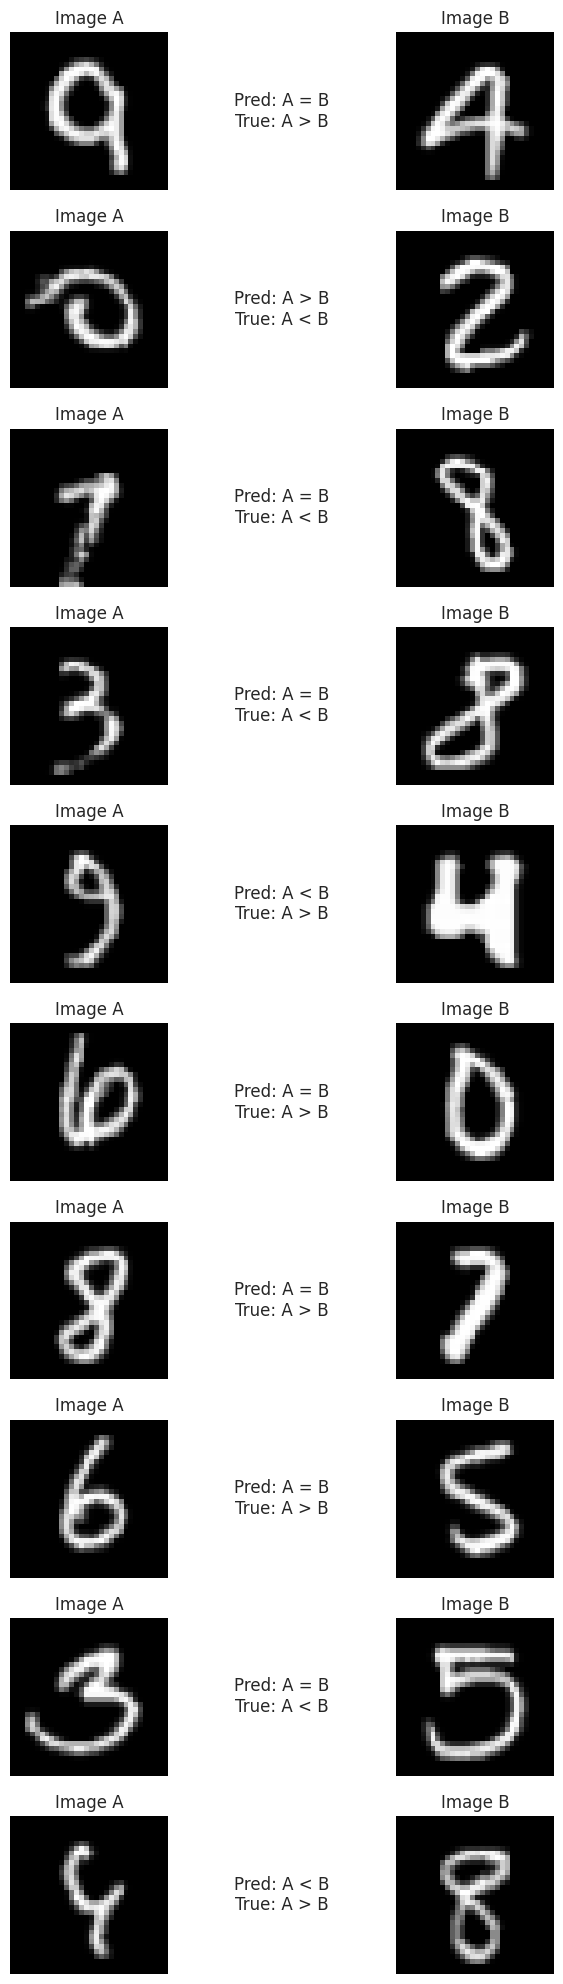

In [116]:
def show_incorrect_predictions(model, dataloader, num_images=5):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    # Itera su tutti i batch nel dataloader
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(predicted.cpu())

    # Concatena tutti i batch raccolti
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    # Trova gli indici delle previsioni errate
    incorrect_predictions = (all_preds != all_labels).nonzero(as_tuple=True)[0]

    print(f"{len(incorrect_predictions)} previsioni errate trovate.")

    if len(incorrect_predictions) == 0:
        print("Nessuna previsione errata trovata.")
        return

    # Limita il numero di immagini errate da mostrare
    num_images = min(num_images, len(incorrect_predictions))

    fig, axes = plt.subplots(num_images, 3, figsize=(6, num_images * 2))
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}
    
    for idx, i in enumerate(incorrect_predictions[:num_images]):
        img_A = all_images[i][0, :, :]
        img_B = all_images[i][1, :, :]
        pred_label = all_preds[i].item()
        true_label = all_labels[i].item()

        # Mostra l'immagine A
        axes[idx, 0].imshow(img_A, cmap='gray')
        axes[idx, 0].set_title('Image A')
        axes[idx, 0].axis('off')

        # Mostra l'etichetta di relazione prevista e reale
        axes[idx, 1].text(0.5, 0.5, f'Pred: {relation_labels[pred_label]}\nTrue: {relation_labels[true_label]}', 
                          fontsize=12, ha='center', va='center')
        axes[idx, 1].axis('off')

        # Mostra l'immagine B
        axes[idx, 2].imshow(img_B, cmap='gray')
        axes[idx, 2].set_title('Image B')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()
    return fig

# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions', show_incorrect_predictions(model, validation_loader, num_images=10))
#show_incorrect_predictions(model, validation_loader, num_images=5)


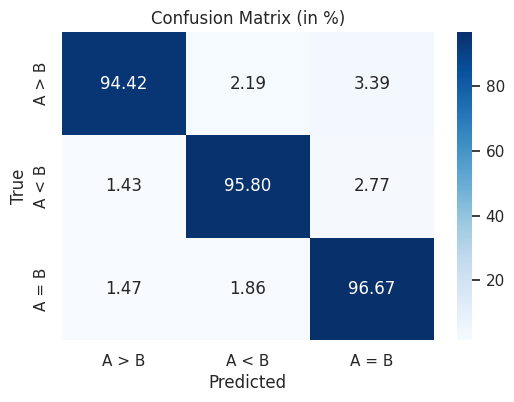

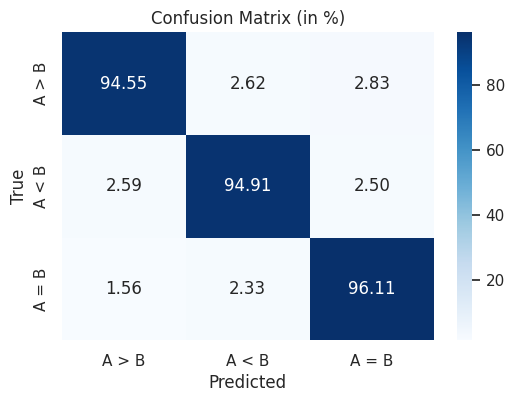

In [117]:
# Funzione per calcolare e stampare la matrice di confusione normalizzata
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Crea la matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalizza la matrice di confusione
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per ogni riga (classe vera)
    
    # Visualizza la matrice di confusione normalizzata in percentuale
    fig = plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['A > B', 'A < B', 'A = B'], 
                yticklabels=['A > B', 'A < B', 'A = B'])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (in %)')
    plt.show()

    return fig

# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', plot_confusion_matrix(model, validation_loader, device))
writer.add_figure('Confusion_matrix_test', plot_confusion_matrix(model, test_loader, device))
#plot_confusion_matrix(model, test_loader, device)


In [118]:
def classification_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Genera il report di classificazione
    report = classification_report(all_labels, all_preds, target_names=['A > B', 'A < B', 'A = B'])
    print(report)

# Stampa il report delle metriche
classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.96      0.95      0.95      2330
       A < B       0.95      0.95      0.95      2357
       A = B       0.95      0.96      0.95      2313

    accuracy                           0.95      7000
   macro avg       0.95      0.95      0.95      7000
weighted avg       0.95      0.95      0.95      7000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [119]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        new_notebook_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        new_notebook_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main.ipynb')


Notebook saved as run32x32_BS=128_LR=0.001_EPOCHS=60_AUG=False_TRA=False_OPT=ADAM.ipynb


In [120]:
writer.close()